# EX1) Comparision of Calibration of Classifiers

- 분류 확률 추정치 반환: predict_proba
- 여러 모델들의 결과 비교해보기

In [10]:
# Dataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [11]:
X_train.shape, X_test.shape

((100, 20), (99900, 20))

In [12]:
# Calibration curves : 4개 모델을 작은 데이터로 훈련해서 해당 커브 (reliability diagrams)를 보고자 함. 

import numpy as np

from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    # decision_function 결과가 곧 predict_proba

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        # Min-max 스케일된 0~1 값 (decision function)
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [13]:
LinearSVC(C=1.0, dual='auto')

LinearSVC(dual='auto')

In [14]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0, dual=True)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest")
]

/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/

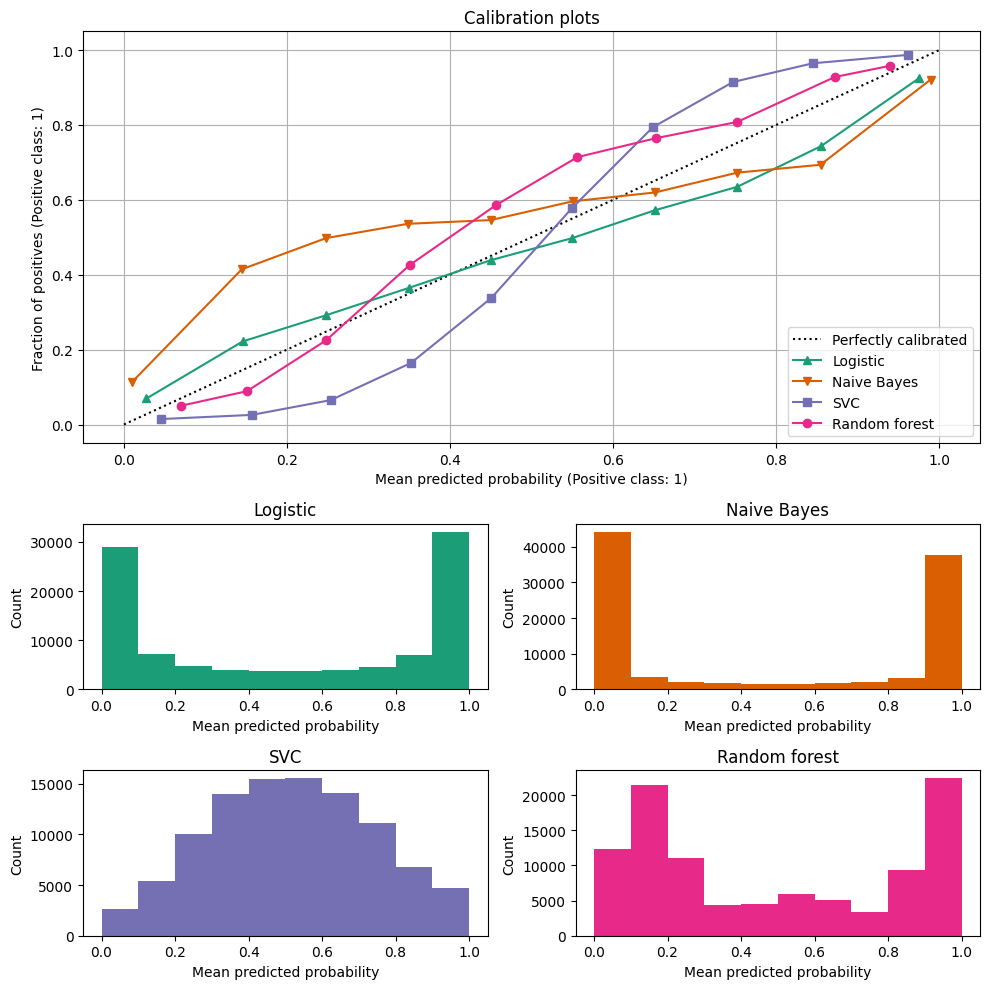

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

plt.tight_layout()
plt.show()


* 해석
    - 가장 위 그래프를 보았을 때, lr이 가장 Loss가 적음
    - nb는 0과 1의 편향성이 두드러짐. 나이브 베이즈 수식의 피쳐들이 독립적일 때 정확한 확률 추정 제공. (하지만 그래프는 양의 상관관계를 갖는 경향이 있음)
    - rf는 0.2와 0.9에 정점을 찍음. 배깅과 랜덤포레스트 방법론을 사용했을 때, 분산으로 인해 0과 1에 가까운 값이 나오는 경향이 있음.
    - svc는 확률 출력하지 않음.(min-max 적용) 

# EX2) Probability Calibration curves

- 클래스 레이블 + 연관 확률 함께 보여주기.
- 신뢰도 다이어그램

In [16]:
# Dataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples = 100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

In [17]:
# Calibration curves

## Gaussian Naive Bayes

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method='isotonic')
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method='sigmoid')

clf_list = [
    (lr, 'Logistic'),
    (gnb, 'Naive Bayes'),
    (gnb_isotonic, 'Naive Bayes + Isotonic'),
    (gnb_sigmoid, 'Naive Bayes + Sigmoid'),
]

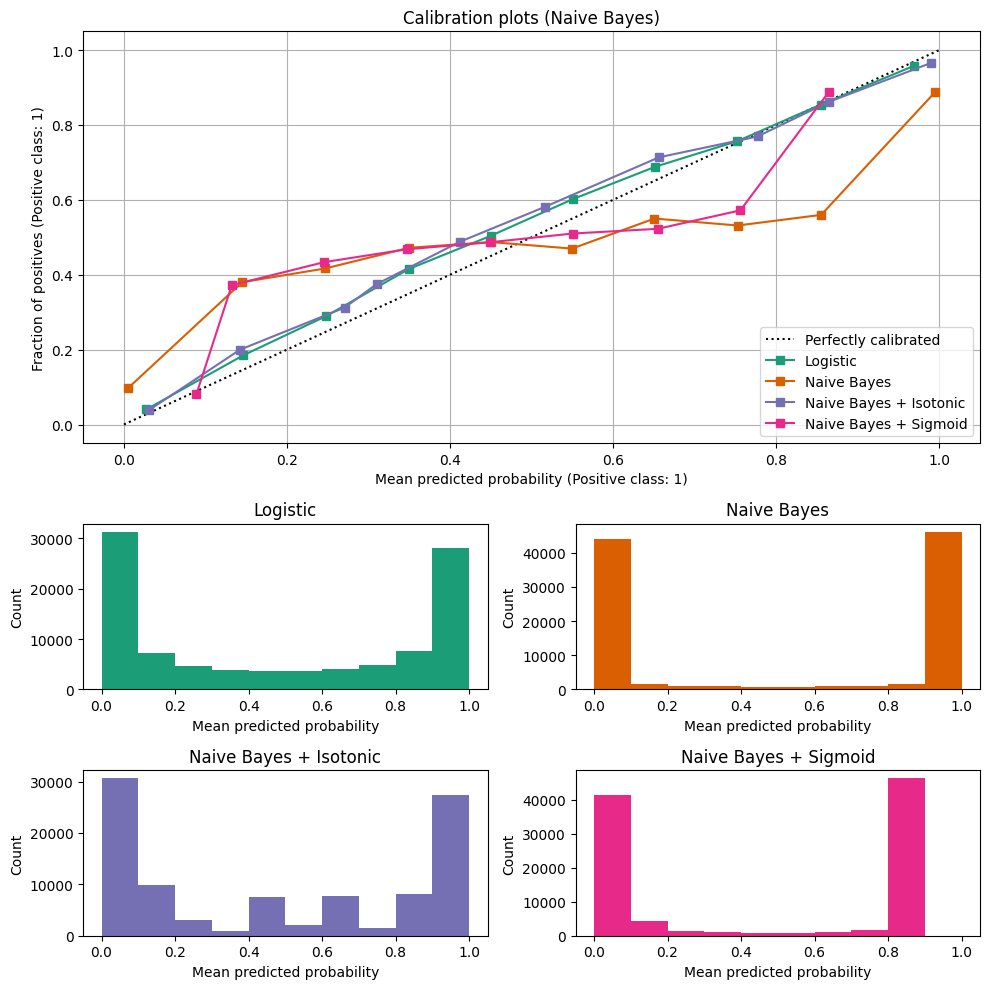

In [18]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap('Dark2')

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots (Naive Bayes)')
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i)
    )
    calibration_displays[name] = display

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i)
    )
    ax.set(title=name, xlabel='Mean predicted probability', ylabel='Count')

plt.tight_layout()
plt.show()

- 보정되지 않은 가우시안은 독립성 가정을 위반하고 치우친 분류기를 생성하는 특징으로 교정 X
    - Isotonic 사용 가우시안을 통해 거의 해결.
    - Sigmoid 사용은 조금 교정됨

In [19]:
# F1 score & ROC AUC

from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_"," ").replace("score","").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098921,0.323178,0.937457,0.872009,0.851408,0.861586
Naive Bayes,0.117608,0.782755,0.940374,0.857400,0.875941,0.866571
Naive Bayes + Isotonic,0.098332,0.370738,0.938613,0.883065,0.836224,0.859007
Naive Bayes + Sigmoid,0.108880,0.368896,0.940201,0.861106,0.871277,0.866161


In [24]:
lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000, dual=True)
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

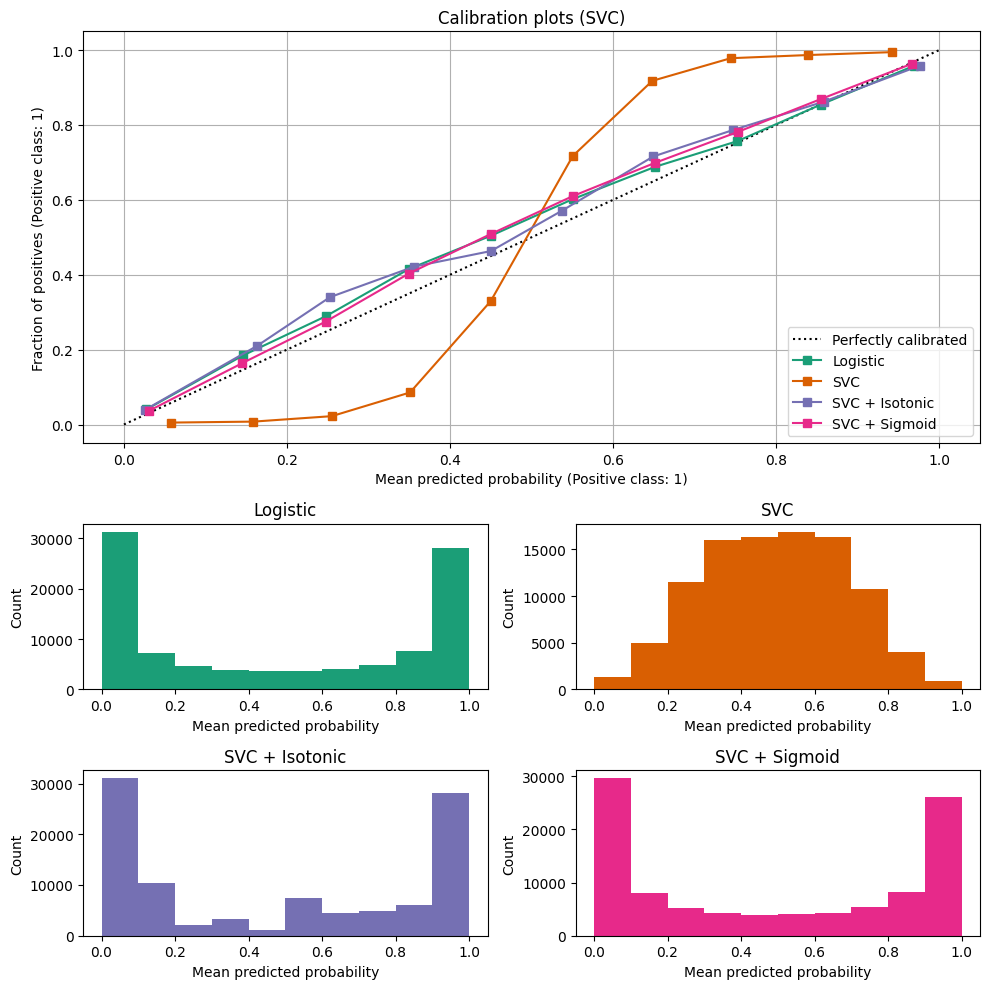

In [26]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap('Dark2')

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots (SVC)')
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i)
    )
    calibration_displays[name] = display

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i)
    )
    ax.set(title=name, xlabel='Mean predicted probability', ylabel='Count')

plt.tight_layout()
plt.show()

In [27]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores['Classifier'].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace('_', ' ').replace('score', '').capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace('_', ' ').replace('score', '').capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index('Classifier')
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098921,0.323178,0.937457,0.872009,0.851408,0.861586
SVC,0.144944,0.465663,0.937596,0.872201,0.851772,0.861865
SVC + Isotonic,0.099827,0.377027,0.936467,0.853032,0.878041,0.865356
SVC + Sigmoid,0.098760,0.321306,0.937530,0.873703,0.848723,0.861032


# EX3) Probability Calibration for 3-class calssification

- 색상 별 실제 클래스를 의미 (red: class 1, green: class 2, blue: class 3)

In [28]:
# Data

import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

X, y = make_blobs(
    n_samples=2000, n_features=2, centers=3, random_state=42, cluster_std=5.0
)

X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:1000], y[600:1000]
X_train_valid, y_train_valid = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

In [29]:
# Fitting and calibration

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

cal_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=25))

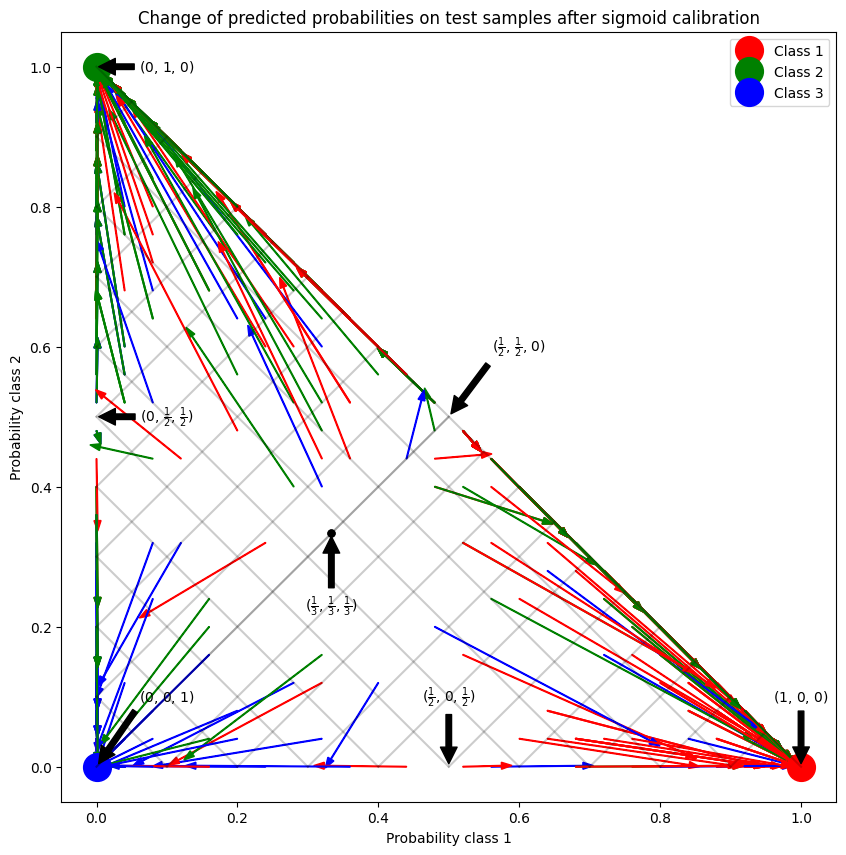

In [40]:
# Compare probabilites

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = ['r', 'g', 'b']

clf_probs = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)

## plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color = colors[y_test[i]],
        head_width = 1e-2,
    )

plt.plot([1.0], [0.0], 'ro', ms=20, label='Class 1')
plt.plot([0.0], [1.0], 'go', ms=20, label='Class 2')
plt.plot([0.0], [0.0], 'bo', ms=20, label='Class 3')

plt.plot([1.0 / 3], [1.0 / 3], 'ko', ms=5)

plt.annotate(
    r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.plot([1.0 / 3], [1.0 / 3], 'ko', ms=5)
plt.annotate(
    r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.annotate(
    r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.annotate(
    r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.annotate(
    r'($0$, $0$, $1$)',
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.annotate(
    r'($1$, $0$, $0$)',
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)
plt.annotate(
    r'($0$, $1$, $0$)',
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords='data',
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center',
    verticalalignment='center',
)

plt.grid(False)
for x in range(0, 11):
    if x != 0:
        x /= 10
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], 'k', alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], 'k', alpha=0.2)

plt.title('Change of predicted probabilities on test samples after sigmoid calibration')
plt.xlabel('Probability class 1')
plt.ylabel('Probability class 2')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc='best')

- 잘못 분류된 경우를 한눈에 파악할 수 있음
- 분류기 바꿔야하나? 보정해야하나?

In [42]:
from sklearn.metrics import log_loss

score = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print('Log-loss of')
print(f' * uncalibrated classifier: {score:.3f}')
print(f' * calibrated classifier: {cal_score:.3f}')

Log-loss of
 * uncalibrated classifier: 1.533
 * calibrated classifier: 0.803


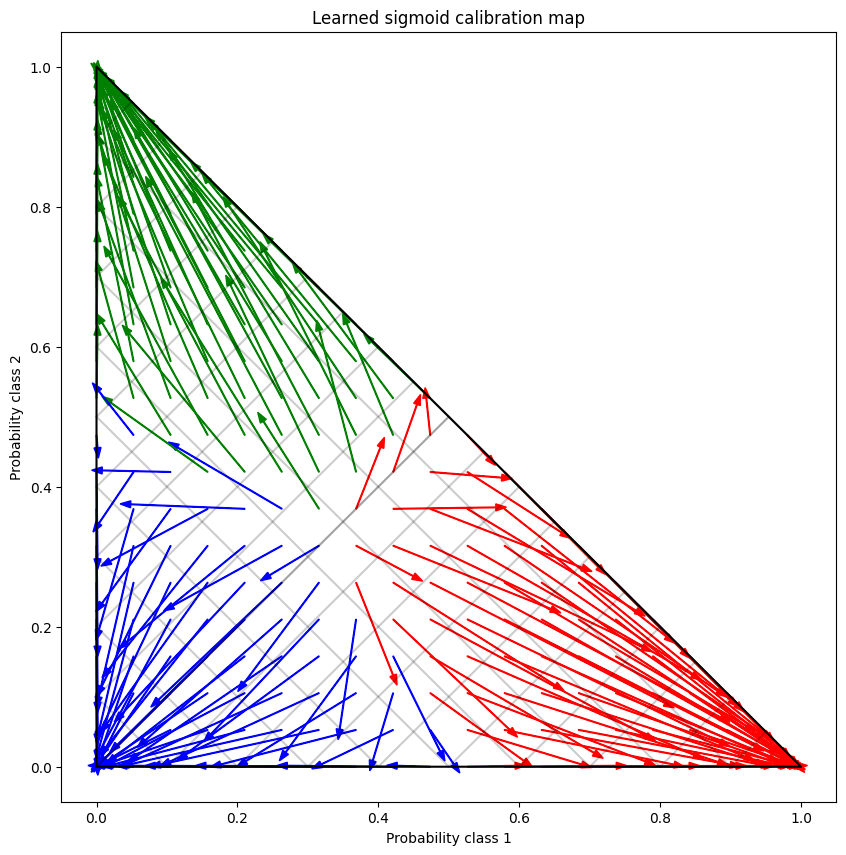

In [43]:
plt.figure(figsize=(10, 10))

p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack(
    [
        calibrator.predict(this_p)
        for calibrator, this_p in zip(calibrated_classifier.calibrators, p.T)
    ]
).T

prediction /= prediction.sum(axis=1)[:, None]

for i in range(prediction.shape[0]):
    plt.arrow(
        p[i, 0],
        p[i, 1],
        prediction[i, 0] - p[i, 0],
        prediction[i, 1] - p[i, 1],
        head_width=1e-2,
        color=colors[np.argmax(p[i])],
    )

plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label='Simplex')

plt.grid(False)
for x in range(0, 11):
    if x != 0:
        x /= 10
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], 'k', alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], 'k', alpha=0.2)

plt.title('Learned sigmoid calibration map')
plt.xlabel('Probability class 1')
plt.ylabel('Probability class 2')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()

# EX4) Probability calibraton of classifier

- 확률과 데이터 분류 결과 시각화

In [55]:
# Generate synthetic dataset

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples = 50000
n_bins = 3

centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

y[:n_samples//2] = 0
y[n_samples//2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42
)

In [56]:
# Gaussian Naive-Bayes

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train) 
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print('Brier score losses: (the smaller the better)')

clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print('No calibration: %1.3f' % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print('With isotonic calibration: %1.3f' % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print('With sigmoid calibration: %1.3f' % clf_sigmoid_score)

Brier score losses: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


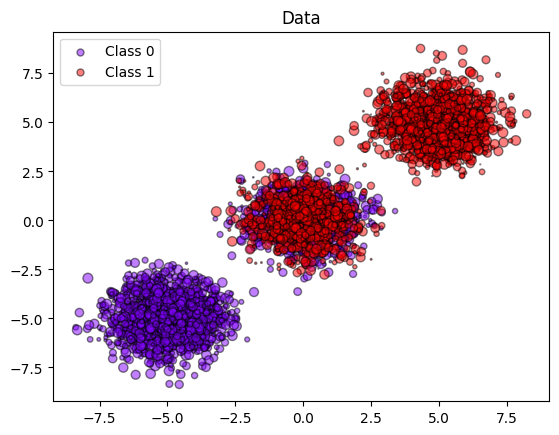

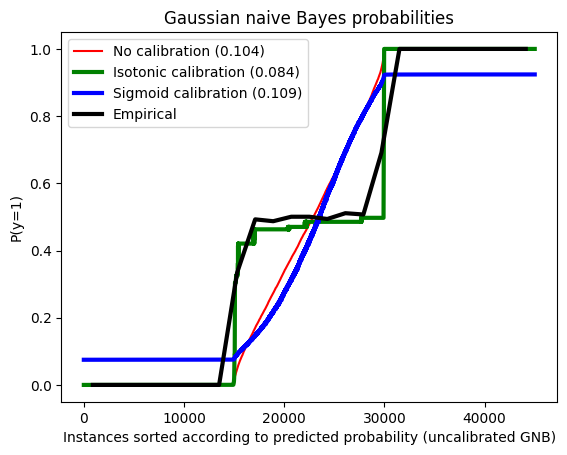

In [61]:
# Plot data and the predicted probabilities

import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(
        this_X[:, 0],
        this_X[:, 1],
        s = this_sw*50,
        c = color[np.newaxis, :],
        alpha = 0.5,
        edgecolors = 'k',
        label = f'Class {this_y}'
    )

plt.legend(loc='best')
plt.title('Data')

plt.figure()

order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(
    prob_pos_isotonic[order],
    'g',
    linewidth=3,
    label='Isotonic calibration (%1.3f)' % clf_isotonic_score,
)
plt.plot(
    prob_pos_sigmoid[order],
    'b',
    linewidth=3,
    label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score,
)
plt.plot(
    np.linspace(0, y_test.size, 51)[1::2],
    y_test[order].reshape(25, -1).mean(1),
    'k',
    linewidth=3,
    label=r'Empirical',
)
plt.ylim([-0.05, 1.05])
plt.xlabel('Instances sorted according to predicted probability (uncalibrated GNB)')
plt.ylabel('P(y=1)')
plt.legend(loc='upper left')
plt.title('Gaussian naive Bayes probabilities')

plt.show()